<h2> Figure with results from base-case trials</h2>

In [1]:
# Some imports to stop some annoying yellow underlines
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import numpy as np
import pandas as pd
import importlib

# Very important lines to run the setup notebooks!!!
%run do_plot_setup.ipynb
%run do_radical_count_setup.ipynb
get_cl_radical_budget = get_cl_radical_budget # Tautology to get rid of the yellow underlines
import cl2_utilities as cl2_utils
import process_cl2_logfile as process_cl2#This underline is unavoidable

# Extract some shared values that are used to facilitate plotting. Call 'display' on any of them to see their contents.
plot_default_properties = get_and_apply_plot_defaults() #Ignore yellow underline
line_default_properties = get_default_line_properties() #Ignore yellow underline
cl2_experiment_constants = get_cl2_experiment_constants() #Ignore yellow underline
(all_conversion_data,all_bypass_data) = get_experimental_data() #Ignore underline. These two dataframes have all the experimental results.

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
importlib.reload(process_cl2)
importlib.reload(cl2_utils)

# ************** START DATA PROCESSING ****************
path = (plot_default_properties['base_directory'] + '/01-06_Final Trials Campaigns/data/01-16_Cl_baseCase_noNaOH.csv')
exp_name = '01-16-25 Base Case'
ftir_path = plot_default_properties['base_directory'] + '/01-06_Final Trials Campaigns/data/01-16_ftir.prn'

info = (path,exp_name,ftir_path)

# Load the file... (path,exp_name,ftir_path)
hush=True
raw_data = process_cl2.extract_data([info[:2]], hush)

# Rebind the ftir
ftir_fields_to_rebind = (('CH4 (PF) 191c average','FTIR: CH4 (ppm)'),('CO2 ppm 191c average','FTIR: CO2 (ppm)'),
                         ('CO ppm 191C (1of2) average','FTIR: CO (ppm)'),('Formaldehyde 191c average','FTIR: CH2O (ppm)'),)

process_cl2.rebind_ftir_prn(raw_data[exp_name],ftir_path,ftir_fields_to_rebind,hush)

for df in raw_data.values():
    try:
        df['FTIR: CH2O (ppm)']-=0.3 #One can see on inspection that the 'baseline' CH2O value is -0.5, not 0, for some reason. We correct that.
        df['FTIR: CO2 (ppm)']-=1.5 #One can see on inspection that the 'baseline' CO2 value is 1.5, not 0, for some reason. We correct that.
    except: #FTIR widget not used, or said 'no reading' the whole time.
        pass

importlib.reload(process_cl2)
trim_params = [(50, 300)]
(data, ax1, ax2) = process_cl2.trim_dataframes(raw_data, trim_params, plot=True, which_field='Cl2 LabJack: Cl2 Node A (mV)', which_df=0)
rf = process_cl2.RemovalFinder(data, "01-16_cl2_misc_follow_ups")

importlib.reload(process_cl2)
#@np.vectorize
def subtract_cl2_zero(mv):# This zero stays fixed within a given campaign but may change from campaign to campaign due to tweaking the Cl2 sensor setup
    return (mv-44.1)

def scale_cl2(mv):
    return (mv-44.1)*30/(145-44.1)

current_experiment = '01-16-25 Base Case'
rf.dump_experiment(current_experiment)
data[current_experiment]['Cl2 LabJack: Cl2 reading minus zero (mV)'] = scale_cl2(data[current_experiment]['Cl2 LabJack: Cl2 Node A (mV)'])
# ************** DONE DATA PROCESSING ****************


# ************** EXTRACT CONVERSIONS ****************
# Select data from only the the experiments we want
all_bypass_data = pd.read_csv("../../_exported_data/bypasses_01-06_cl2_final_trials.csv")
all_conversion_data = pd.read_csv("../../_exported_data/conversions_01-06_cl2_final_trials.csv")

exps = ["01-16-25 Base Case"]
bypass_data = all_bypass_data[all_bypass_data["experiment_name"].isin(exps)]
conversion_data = all_conversion_data[all_conversion_data["experiment_name"].isin(exps)]

# Extract the values and 95% CI from the CH4 conversion data
((ch4_conversions,ch4_95_ci),) = cl2_utils.extract_spectrometer_data_from_conversions(conversion_data,
            fields=['Selected: CH4 (ppm)'], percent_accuracy_95 = cl2_experiment_constants.picarro_percent_accuracy_95, absolute_accuracy_95 = cl2_experiment_constants.picarro_absolute_accuracy_95)

# Extract the values and 95% CI from the Cl2 conversion data
cl2_tank_ppms = np.array([1000 for b in conversion_data['Cl2 LabJack: Cl2 reading minus zero (mV) baseline']])
(cl2_baseline, cl2_conversions, cl2_conversion_95_ci) = cl2_utils.extract_cl2_data_from_conversions(conversion_data,bypass_data,cl2_tank_ppms,cl2_experiment_constants.cl2_mfc_sccm_accuracy_95,cl2_experiment_constants.cl2_node_percent_accuracy_95)
inlet_cl2 = cl2_baseline

# Extract the means and 95% CI's for each gas in each bypass period
fields = ['FTIR: CO2 (ppm)','FTIR: CO (ppm)','FTIR: CH2O (ppm)']
((co2,co2_95_ci),(co,co_95_ci),(ch2o,ch2o_95_ci)) = cl2_utils.extract_spectrometer_data_from_bypass(conversion_data,bypass_data,fields,percent_accuracy_95=5,absolute_accuracy_95=1)

# Get the means and 95% CI for the sum of all of them
co_co2_ch2o_sum = co2+co+ch2o
co_co2_ch2o_95_ci = 2*np.sqrt((0.5*co2_95_ci)**2 + (0.5*co_95_ci)**2 + (0.5*ch2o_95_ci)**2)
# ************** EXTRACT CONVERSIONS ****************

plt.close()


/Users/maxkessler/Documents/GitHub/Fall-2024-Cl2/_shared_packages/process_cl2_logfile.py:38: FutureWarning: Support for nested sequences for 'parse_dates' in pd.read_csv is deprecated. Combine the desired columns with pd.to_datetime after parsing instead.
  dfs = {label: pd.read_csv(path,parse_dates={'Timestamp':[0,1]}) for label,path in zip(labels,paths)}
/Users/maxkessler/Documents/GitHub/Fall-2024-Cl2/_shared_packages/process_cl2_logfile.py:494: FutureWarning: Support for nested sequences for 'parse_dates' in pd.read_csv is deprecated. Combine the desired columns with pd.to_datetime after parsing instead.
  prn = pd.read_csv(new_prn_path,sep='\t',parse_dates={'Timestamp':[1,2]},date_parser=lambda x: pd.to_datetime(x, errors="coerce"))
/Users/maxkessler/Documents/GitHub/Fall-2024-Cl2/_shared_packages/process_cl2_logfile.py:494: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'ob

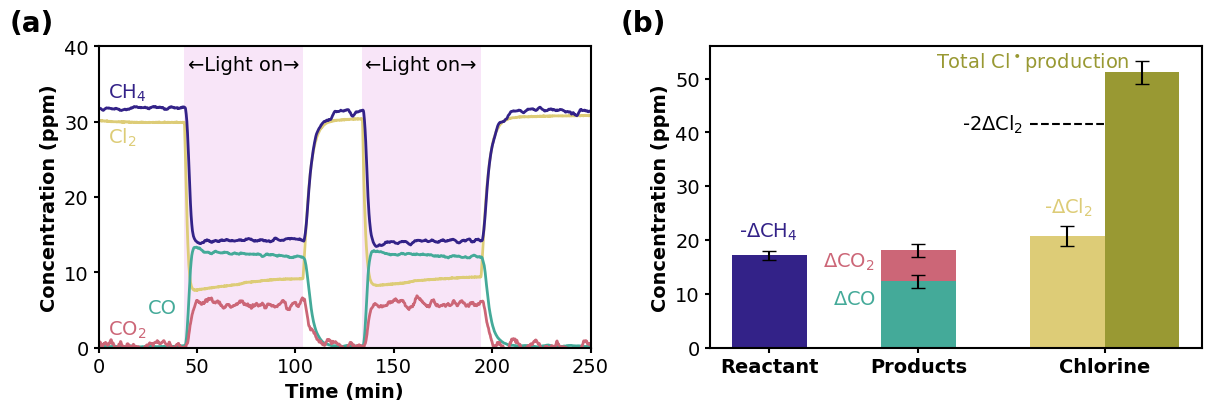

In [3]:
#importlib.reload(process_cl2)

# ************** MAKE PLOT ****************
(fig,((ax_a,ax_b)))=plt.subplots(1,2,figsize=(plot_default_properties['figure_width'],4))
for ax in [ax_a, ax_b]:
    ax.tick_params(width=plot_default_properties['box_linewidth'])
    for spine in ax.spines.values():
        spine.set_linewidth(plot_default_properties['box_linewidth'])

# a
ax_a.text(-0.18,1.05, "(a)", transform=ax_a.transAxes, size=plot_default_properties['subplot_letter_size'], weight='bold')

# Add the UV light overlays
(on_times,off_times) = process_cl2.find_UV_changes(data[current_experiment]['UV Light: Actual Status'],data[current_experiment]['Minutes'])
for i in range(len(on_times)):
    ax_a.axvspan(on_times.iloc[i],off_times.iloc[i], color='m', alpha=0.1, lw=0)
ax_a.text(.295,0.97, '←Light on→',ha='center',va='top',transform=ax_a.transAxes)
ax_a.text(0.655,0.97, '←Light on→',ha='center',va='top',transform=ax_a.transAxes)
#ax_a.plot(data[current_experiment]['Minutes'],10*data[current_experiment]['UV Light: Actual Status'],color='xkcd:purple',label='UV Light: Status (AU)')

#rf.plot_baseline_and_samples(current_experiment,which_field='Cl2 LabJack: Cl2 reading minus zero (mV)',color='g',marker='o',ax=ax_a,do_shading=False)
cl2_utils.do_timeseries(ax_a,line_default_properties,'Cl2',data[current_experiment]['Minutes'],data[current_experiment]['Cl2 LabJack: Cl2 reading minus zero (mV)'])
cl2_utils.do_timeseries(ax_a,line_default_properties,'CH4',data[current_experiment]['Minutes'],data[current_experiment]['FTIR: CH4 (ppm)'])
cl2_utils.do_timeseries(ax_a,line_default_properties,'CO',data[current_experiment]['Minutes'],data[current_experiment]['FTIR: CO (ppm)'])
cl2_utils.do_timeseries(ax_a,line_default_properties,'CO2',data[current_experiment]['Minutes'],data[current_experiment]['FTIR: CO2 (ppm)'])

# Labeling
labels = (('Cl2',5,26.5,0),
          ('CH4',5,32.5,0),
          ('CO',25,4,0),
          ('CO2',5,1,0))
cl2_utils.label_tslines(ax_a,line_default_properties,labels)

#print(rf.translate_tags("UV_distance_conv=50; dummy='whatever'")['UV_distance_conv'])
ax_a.set_xlim(0,250)
ax_a.set_ylim(0,40)
ax_a.set_ylabel('Concentration (ppm)',fontweight=plot_default_properties['font_weight'])
ax_a.set_xlabel('Time (min)',fontweight=plot_default_properties['font_weight'])


# b
ax_b.text(-0.18, 1.05, "(b)", transform=ax_b.transAxes, size=plot_default_properties['subplot_letter_size'], weight='bold')

(rad_count, rad_count_CI) = get_cl_radical_budget(30)
bar_labels = ['Reactant', 'Products', 'Chlorine']
bars_data = [
    ('Reactant', [[np.mean(ch4_conversions)], [np.mean(ch4_95_ci)]]),
    ('Products', [[np.mean(co), np.mean(co2)], [np.mean(co_95_ci), np.mean(co2_95_ci)]]),
    ('Chlorine', [[np.mean(cl2_conversions)], [np.mean(cl2_conversion_95_ci)]]),
    ('Cl Efficiency', [[rad_count], [rad_count_CI]])
]

# Labeling
labels = [
    ('CH4', .06, .35, 0, '-$\Delta$CH$_4$'),
    ('CO', .25, .13, 0, '$\Delta$CO'),
    ('CO2', .23, .25, 0, '$\Delta$CO$_2$'),
    ('Cl2', .68, .43, 0, '-$\Delta$Cl$_2$'),
    ('Cl* Efficiency', .46, .91, 0, 'Total Cl$^\\bullet$production')
]

ax_b.set_ylim(0,56)

# Plot the bars
x_positions = [0, 1, 2, 2.5]  # Fourth bar offset by 0.3
j = 0

for i, (label, bardata) in enumerate(bars_data):
    bottom = 0
    for k, (value, error) in enumerate(zip(*bardata)):
        if i == 2:
            # Plot third and fourth bars close together
            x_pos = x_positions[i + k]
        else:
            x_pos = x_positions[i]
        
        ax_b.bar(x_pos, value, bottom=bottom, width=0.5, color=line_default_properties[labels[j][0]]['color']) 
        ax_b.errorbar(x_pos, value + bottom, yerr=error, fmt='none', ecolor='black', capsize=5)
        bottom += value
        j += 1
        #print(label," ",k,": ",value)

# Add dashed horizontal line
ax_b.hlines(y=2*np.mean(cl2_conversions), xmin=1.75, xmax=2.25, colors='black', linestyles='dashed')
ax_b.text(1.7, 2*np.mean(cl2_conversions), '-2$\Delta$Cl$_2$', rotation=0, color='black', ha='right', va='center')

# Setup x-axis labels
ax_b.set_xticks([0, 1, 2.25])
ax_b.set_xticklabels(['Reactant', 'Products', 'Chlorine'],fontweight=plot_default_properties['font_weight'])

for (l, x, y, r, ll) in labels:
    t = ll
    c = line_default_properties[l]['color']
    ax_b.text(x, y, t, rotation=r, color=c, ha='left', va='bottom', transform=ax_b.transAxes)

ax_b.set_ylabel('Concentration (ppm)',fontweight=plot_default_properties['font_weight'])

plt.savefig('exported_images/base_case_results.png', bbox_inches='tight',dpi=300)
plt.show()

/Users/maxkessler/Documents/GitHub/Fall-2024-Cl2/_shared_packages/process_cl2_logfile.py:38: FutureWarning: Support for nested sequences for 'parse_dates' in pd.read_csv is deprecated. Combine the desired columns with pd.to_datetime after parsing instead.
  dfs = {label: pd.read_csv(path,parse_dates={'Timestamp':[0,1]}) for label,path in zip(labels,paths)}
/Users/maxkessler/Documents/GitHub/Fall-2024-Cl2/_shared_packages/process_cl2_logfile.py:494: FutureWarning: Support for nested sequences for 'parse_dates' in pd.read_csv is deprecated. Combine the desired columns with pd.to_datetime after parsing instead.
  prn = pd.read_csv(new_prn_path,sep='\t',parse_dates={'Timestamp':[1,2]},date_parser=lambda x: pd.to_datetime(x, errors="coerce"))
/Users/maxkessler/Documents/GitHub/Fall-2024-Cl2/_shared_packages/process_cl2_logfile.py:494: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'ob

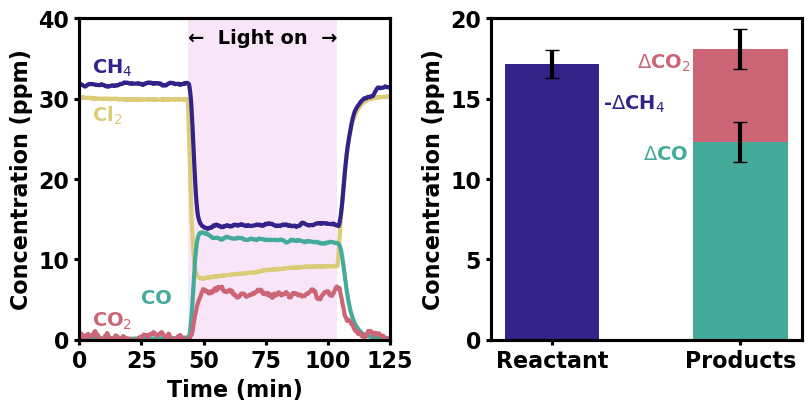

In [4]:
importlib.reload(process_cl2)
importlib.reload(cl2_utils)

line_default_properties_custom = {'CH4':{'color':'#332288','marker':'.','linestyle':'--','linewidth':3,'text':'-$\Delta$CH$_4$','tstext':'CH$_4$','weight':'bold'},
                    'Cl2':{'color':'#DDCC77','marker':'.','linestyle':'--','linewidth':3,'text':'-$\Delta$Cl$_2$','tstext':'Cl$_2$','weight':'bold'},
                    'CO2':{'color':'#CC6677','marker':'.','linestyle':'--','linewidth':3,'text':'$\Delta$CO$_2$','tstext':'CO$_2$','weight':'bold'},
                    'CO':{'color':'#44AA99','marker':'.','linestyle':'--','linewidth':3,'text':'$\Delta$CO','tstext':'CO','weight':'bold'}
                    }

# ************** START DATA PROCESSING ****************
path = (plot_default_properties['base_directory'] + '/01-06_Final Trials Campaigns/data/01-16_Cl_baseCase_noNaOH.csv')
exp_name = '01-16-25 Base Case'
ftir_path = plot_default_properties['base_directory'] + '/01-06_Final Trials Campaigns/data/01-16_ftir.prn'

info = (path,exp_name,ftir_path)

# Load the file... (path,exp_name,ftir_path)
hush=True
raw_data = process_cl2.extract_data([info[:2]], hush)

# Rebind the ftir
ftir_fields_to_rebind = (('CH4 (PF) 191c average','FTIR: CH4 (ppm)'),('CO2 ppm 191c average','FTIR: CO2 (ppm)'),
                         ('CO ppm 191C (1of2) average','FTIR: CO (ppm)'),('Formaldehyde 191c average','FTIR: CH2O (ppm)'),)

process_cl2.rebind_ftir_prn(raw_data[exp_name],ftir_path,ftir_fields_to_rebind,hush)

for df in raw_data.values():
    try:
        df['FTIR: CH2O (ppm)']-=0.3 #One can see on inspection that the 'baseline' CH2O value is -0.5, not 0, for some reason. We correct that.
        df['FTIR: CO2 (ppm)']-=1.5 #One can see on inspection that the 'baseline' CO2 value is 1.5, not 0, for some reason. We correct that.
    except: #FTIR widget not used, or said 'no reading' the whole time.
        pass

importlib.reload(process_cl2)
trim_params = [(50, 175)]
(data, ax1, ax2) = process_cl2.trim_dataframes(raw_data, trim_params, plot=True, which_field='Cl2 LabJack: Cl2 Node A (mV)', which_df=0)
rf = process_cl2.RemovalFinder(data, "01-16_cl2_misc_follow_ups")

importlib.reload(process_cl2)
#@np.vectorize
def subtract_cl2_zero(mv):# This zero stays fixed within a given campaign but may change from campaign to campaign due to tweaking the Cl2 sensor setup
    return (mv-44.1)

def scale_cl2(mv):
    return (mv-44.1)*30/(145-44.1)

current_experiment = '01-16-25 Base Case'
rf.dump_experiment(current_experiment)
data[current_experiment]['Cl2 LabJack: Cl2 reading minus zero (mV)'] = scale_cl2(data[current_experiment]['Cl2 LabJack: Cl2 Node A (mV)'])
# ************** DONE DATA PROCESSING ****************


# ************** EXTRACT CONVERSIONS ****************
# Select data from only the the experiments we want
all_bypass_data = pd.read_csv("../../_exported_data/bypasses_01-06_cl2_final_trials.csv")
all_conversion_data = pd.read_csv("../../_exported_data/conversions_01-06_cl2_final_trials.csv")

exps = ["01-16-25 Base Case"]
bypass_data = all_bypass_data[all_bypass_data["experiment_name"].isin(exps)]
conversion_data = all_conversion_data[all_conversion_data["experiment_name"].isin(exps)]

# Extract the values and 95% CI from the CH4 conversion data
((ch4_conversions,ch4_95_ci),) = cl2_utils.extract_spectrometer_data_from_conversions(conversion_data,
            fields=['Selected: CH4 (ppm)'], percent_accuracy_95 = cl2_experiment_constants.picarro_percent_accuracy_95, absolute_accuracy_95 = cl2_experiment_constants.picarro_absolute_accuracy_95)

# Extract the values and 95% CI from the Cl2 conversion data
cl2_tank_ppms = np.array([1000 for b in conversion_data['Cl2 LabJack: Cl2 reading minus zero (mV) baseline']])
(cl2_baseline, cl2_conversions, cl2_conversion_95_ci) = cl2_utils.extract_cl2_data_from_conversions(conversion_data,bypass_data,cl2_tank_ppms,cl2_experiment_constants.cl2_mfc_sccm_accuracy_95,cl2_experiment_constants.cl2_node_percent_accuracy_95)
inlet_cl2 = cl2_baseline

# Extract the means and 95% CI's for each gas in each bypass period
fields = ['FTIR: CO2 (ppm)','FTIR: CO (ppm)','FTIR: CH2O (ppm)']
((co2,co2_95_ci),(co,co_95_ci),(ch2o,ch2o_95_ci)) = cl2_utils.extract_spectrometer_data_from_bypass(conversion_data,bypass_data,fields,percent_accuracy_95=5,absolute_accuracy_95=1)

# Get the means and 95% CI for the sum of all of them
co_co2_ch2o_sum = co2+co+ch2o
co_co2_ch2o_95_ci = 2*np.sqrt((0.5*co2_95_ci)**2 + (0.5*co_95_ci)**2 + (0.5*ch2o_95_ci)**2)
# ************** EXTRACT CONVERSIONS ****************

plt.close()

#importlib.reload(process_cl2)

# ************** MAKE PLOT ****************
(fig,((ax_a,ax_b)))=plt.subplots(1,2,figsize=(plot_default_properties['figure_width']/1.5,4))
for ax in [ax_a, ax_b]:
    ax.tick_params(width=plot_default_properties['box_linewidth']*1.5)
    for spine in ax.spines.values():
        spine.set_linewidth(plot_default_properties['box_linewidth']*1.5)

# a

# Add the UV light overlays
(on_times,off_times) = process_cl2.find_UV_changes(data[current_experiment]['UV Light: Actual Status'],data[current_experiment]['Minutes'])
for i in range(len(on_times)):
    ax_a.axvspan(on_times.iloc[i],off_times.iloc[i], color='m', alpha=0.1, lw=0)
ax_a.text(.59,0.97, '←  Light on  →',ha='center',va='top',transform=ax_a.transAxes, fontsize=14, fontweight=plot_default_properties['font_weight'])
#ax_a.plot(data[current_experiment]['Minutes'],10*data[current_experiment]['UV Light: Actual Status'],color='xkcd:purple',label='UV Light: Status (AU)')

#rf.plot_baseline_and_samples(current_experiment,which_field='Cl2 LabJack: Cl2 reading minus zero (mV)',color='g',marker='o',ax=ax_a,do_shading=False)
cl2_utils.do_timeseries(ax_a,line_default_properties_custom,'Cl2',data[current_experiment]['Minutes'],data[current_experiment]['Cl2 LabJack: Cl2 reading minus zero (mV)'])
cl2_utils.do_timeseries(ax_a,line_default_properties_custom,'CH4',data[current_experiment]['Minutes'],data[current_experiment]['FTIR: CH4 (ppm)'])
cl2_utils.do_timeseries(ax_a,line_default_properties_custom,'CO',data[current_experiment]['Minutes'],data[current_experiment]['FTIR: CO (ppm)'])
cl2_utils.do_timeseries(ax_a,line_default_properties_custom,'CO2',data[current_experiment]['Minutes'],data[current_experiment]['FTIR: CO2 (ppm)'])

# Labeling
labels = (('Cl2',5,26.5,0),
          ('CH4',5,32.5,0),
          ('CO',25,4,0),
          ('CO2',5,1,0))
cl2_utils.label_tslines(ax_a,line_default_properties_custom,labels)

#print(rf.translate_tags("UV_distance_conv=50; dummy='whatever'")['UV_distance_conv'])
ax_a.set_xlim(0,125)
ax_a.set_ylim(0,40)
ax_a.set_yticks(range(0, 41, 10))
ax_a.set_yticklabels([str(i) for i in range(0, 41, 10)], fontweight=plot_default_properties['font_weight'], fontsize=16)
ax_a.set_ylabel('Concentration (ppm)',fontweight=plot_default_properties['font_weight'], fontsize=16)
ax_a.set_xlabel('Time (min)', fontweight=plot_default_properties['font_weight'], fontsize=16)
ax_a.set_xticklabels([0, 25, 50, 75, 100, 125], fontweight=plot_default_properties['font_weight'], fontsize=16)

# b

(rad_count, rad_count_CI) = get_cl_radical_budget(30)
bar_labels = ['Reactant', 'Products']
bars_data = [
    ('Reactant', [[np.mean(ch4_conversions)], [np.mean(ch4_95_ci)]]),
    ('Products', [[np.mean(co), np.mean(co2)], [np.mean(co_95_ci), np.mean(co2_95_ci)]])
]

# Labeling
labels = [
    ('CH4', .36, .7, 0, '-$\Delta$CH$_4$'),
    ('CO', .49, .55, 0, '$\Delta$CO'),
    ('CO2', .47, .83, 0, '$\Delta$CO$_2$')
]

ax_b.set_ylim(0,20)
ax_b.set_yticks(range(0, 21, 5))
ax_b.set_yticklabels([str(i) for i in range(0, 21, 5)], fontweight=plot_default_properties['font_weight'], fontsize=16)

# Plot the bars
x_positions = [0, 1] 
j = 0

for i, (label, bardata) in enumerate(bars_data):
    bottom = 0
    for k, (value, error) in enumerate(zip(*bardata)):
        if i == 2:
            # Plot third and fourth bars close together
            x_pos = x_positions[i + k]
        else:
            x_pos = x_positions[i]
        
        ax_b.bar(x_pos, value, bottom=bottom, width=0.5, color=line_default_properties_custom[labels[j][0]]['color']) 
        ax_b.errorbar(x_pos, value + bottom, yerr=error, fmt='none', ecolor='black', capsize=5, linewidth=3)
        bottom += value
        j += 1
        #print(label," ",k,": ",value)

# Setup x-axis labels
ax_b.set_xticks([0, 1])
ax_b.set_xticklabels(['Reactant', 'Products'],fontweight=plot_default_properties['font_weight'], fontsize=16)

for (l, x, y, r, ll) in labels:
    t = ll
    c = line_default_properties_custom[l]['color']
    ax_b.text(x, y, t, rotation=r, color=c, ha='left', va='bottom', transform=ax_b.transAxes, fontweight=plot_default_properties['font_weight'], fontsize=14)

ax_b.set_ylabel('Concentration (ppm)',fontweight=plot_default_properties['font_weight'], fontsize=16)

plt.savefig('exported_images/base_case_results_for_slides.png', bbox_inches='tight',dpi=300)
plt.show()
